# 2nd model: [AlBERTo](https://huggingface.co/m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0)

In this script, we'll use a pre-trained BERT
(https://arxiv.org/abs/1810.04805) model for text classification
using PyTorch and PyTorch-Transformers
(https://github.com/huggingface/pytorch-transformers). This script
is based on "Predicting Movie Review Sentiment with BERT on TF Hub"
(https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb)
by Google and "BERT Fine-Tuning Tutorial with PyTorch"
(https://mccormickml.com/2019/07/22/BERT-fine-tuning/) by Chris
McCormick.

**Note that using a GPU with this script is highly recommended.**


In [1]:
!pip3 install transformers
!pip3 install torch torchvision
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from pathlib import Path

import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification

from transformers import AdamW, get_linear_schedule_with_warmup

from distutils.version import LooseVersion as LV

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

import io
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""

print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 2.5.1+cu121 Device: cuda [Tesla T4]


<ipython-input-3-d1a1187c676c>:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert(LV(torch.__version__) >= LV("1.0.0"))


# Loading the dataset

N.B. If you rerun this code on Colab, remember to comment the `!git clone` command, or to delete runtime before rerunning.

In [4]:
try:
    from google.colab import drive
    #drive.mount('/content/drive')
    COLAB = True
    !git clone https://github.com/g-fabiani4-unipi/txa_project.git
    %cd txa_project
except:
    COLAB = False

Cloning into 'txa_project'...
remote: Enumerating objects: 505, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 505 (delta 46), reused 55 (delta 20), pack-reused 375 (from 1)
Receiving objects: 100% (505/505), 163.19 MiB | 11.64 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Updating files: 100% (63/63), done.
/content/txa_project


In [5]:
#N.B. We have two test sets

data_dir = Path("./data")

training_set_dir = "haspeede2_dev"
training_file = "haspeede2_dev_taskAB.tsv"

test_set_dir = "haspeede2_reference"
test_file_tweets = "haspeede2_reference_taskAB-tweets.tsv"
test_file_news = "haspeede2_reference_taskAB-news.tsv"

train_path = data_dir / training_set_dir / training_file
test_path_tweets = data_dir / test_set_dir / test_file_tweets
test_path_news = data_dir / test_set_dir / test_file_news

In [6]:
def load_tsv_file(file_path):
    """
    Loads a .tvs file w/ or w/out an header in a pandas dataframe w/ columns
    'id', 'text' and 'hs' ('stereotype' is ignored).
    """
    try:

        df = pd.read_csv(file_path, sep='\\t', header=None, engine='python') #engine='python' → else tweets w/ id 8094 and 9261 are not loaded
        # Check for header → train file
        if df.iloc[0, 0] == 'id': #df.iloc[row, col]
            df = df.iloc[1:]  # If header → skip first line

        df.columns = ['id', 'text', 'hs', 'stereotype'] #rename col
        df = df[['id', 'text', 'hs']] #select the cols of intereste

        #Convert number to int
        df['id'] = df['id'].astype(int)
        df['hs'] = df['hs'].astype(int)

        return df
    except Exception as e:
        raise ValueError(f"Errore durante la lettura del file: {e}")

In [7]:
#Dataframes w/ the datasets
df_train = load_tsv_file(train_path)
df_test_tweets = load_tsv_file(test_path_tweets)
df_test_news = load_tsv_file(test_path_news)

In [8]:
def list_x_y(df):
  """
  For a df (dataset), create for each record (tweet) a list contaning the text (x) and a list contaning its label (y),
  so that their indexes correspond.
  """
  x = list()
  y = list()
  for index, row in df.iterrows():
      x.append(row['text'])
      y.append(row['hs'])
  return x, y

x_train, y_train = list_x_y(df_train)
x_test_tweets, y_test_tweets = list_x_y(df_test_tweets)
x_test_news, y_test_news = list_x_y(df_test_news)

In [9]:
len(x_train),len(y_train),  len(x_test_tweets),len(y_test_tweets),  len(x_test_news),len(y_test_news)


(6839, 6839, 1263, 1263, 500, 500)

In [10]:
set(y_train), set(y_test_tweets), set(y_test_news)

({0, 1}, {0, 1}, {0, 1})

In [11]:
sample_idx = 0
print(x_train[sample_idx])
print(y_train[sample_idx])

È terrorismo anche questo, per mettere in uno stato di soggezione le persone e renderle innocue, mentre qualcuno... URL 
0


In [12]:
#y_train[sample_idx]

# Preparation of the text for BERT.

The tokenizer is already fit on the same dataset on which BERT has been pretrained and it is included in the BERT model.
To be properly handled by BERT we need to add the `[CLS]` token at the beginning of each tweet.

In [13]:
sentences_train = ["[CLS] " + s for s in x_train]
sentences_test_tweets = ["[CLS] " + s for s in x_test_tweets]
sentences_test_news = ["[CLS] " + s for s in x_test_news]

labels_train = y_train
labels_test_tweets = y_test_tweets
labels_test_news = y_test_news

In [14]:
sentences_train[0]

'[CLS] È terrorismo anche questo, per mettere in uno stato di soggezione le persone e renderle innocue, mentre qualcuno... URL '

Next we use the BERT tokenizer to convert the sentences into tokens that match the data BERT was trained on.

In [15]:
BERTMODEL = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0" #dbmdz/bert-base-italian-cased

tokenizer = BertTokenizer.from_pretrained(BERTMODEL)
tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

BertTokenizer(name_or_path='m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [16]:
from tqdm import tqdm #library that displays progress bars

tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test_tweets  = [tokenizer.tokenize(s) for s in tqdm(sentences_test_tweets)]
tokenized_test_news  = [tokenizer.tokenize(s) for s in tqdm(sentences_test_news)]

100%|██████████| 500/500 [00:00<00:00, 3108.96it/s]


In [17]:
sentences_train[0]

'[CLS] È terrorismo anche questo, per mettere in uno stato di soggezione le persone e renderle innocue, mentre qualcuno... URL '

In [18]:
print ("The full tokenized first training sentence:")
print (tokenized_train[0])

The full tokenized first training sentence:
['[CLS]', 'e', 'terrorismo', 'anche', 'questo', '[UNK]', 'per', 'mettere', 'in', 'uno', 'stato', 'di', 'soggezione', 'le', 'persone', 'e', 'render', '##le', 'innocue', '[UNK]', 'mentre', 'qualcuno', '[UNK]', '[UNK]', '[UNK]', 'ur', '##l']


BERT has several embeddings that pass through many levels...

...but this is not a variable encoding! **BERT exploits fixed-length encoding**

Thus, we set the maximum sequence lengths for our training and test sentences as `MAX_LEN_TRAIN` and `MAX_LEN_TEST`. The maximum length supported by the used BERT model is 512.

The token `[SEP]` (separation token) is another special token required by BERT at the end of the sentence, e.g., useful in Q/A.

In [19]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 512

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test_tweets  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test_tweets]
tokenized_test_news  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test_news]

print ("The truncated tokenized first training sentence:")
print (tokenized_train[0])

The truncated tokenized first training sentence:
['[CLS]', 'e', 'terrorismo', 'anche', 'questo', '[UNK]', 'per', 'mettere', 'in', 'uno', 'stato', 'di', 'soggezione', 'le', 'persone', 'e', 'render', '##le', 'innocue', '[UNK]', 'mentre', 'qualcuno', '[UNK]', '[UNK]', '[UNK]', 'ur', '##l', 'SEP']


Next we use the BERT tokenizer to convert each token into an integer index in the BERT vocabulary *= Which is the proper embedding to get?*

We also pad any shorter sequences to `MAX_LEN_TRAIN` or `MAX_LEN_TEST` indices with trailing zeros.


In [20]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test_tweets = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test_tweets]
ids_test_tweets = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test_tweets])

ids_test_news = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test_news]
ids_test_news = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test_news])

print ("The indices of the first training sentence:")
print (ids_train[0])

The indices of the first training sentence:
[    2    13  4923    23    79     1    22   605    24   153   184    12
 49535    40   234    13 20897  1041 90954     1   408   271     1     1
     1 14013   902     1     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


BERT also requires *attention masks*, with 1 for each real token in the sequences and 0 for the padding.

The attention mask tells which positions you have tokens in and which are just empty and do not have tokens.

In [21]:
amasks_train, amasks_test_tweets, amasks_test_news = [], [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

for seq in ids_test_tweets:
  seq_mask = [float(i>0) for i in seq]
  amasks_test_tweets.append(seq_mask)

for seq in ids_test_news:
  seq_mask = [float(i>0) for i in seq]
  amasks_test_news.append(seq_mask)

We use scikit-learn's train_test_split() to use 10% of our training data as a validation set.

So far, we are working with Python lists, i.e., lists of integers. In order for these lists to be correctly handled by BERT, we must convert our lists into other dedicated structures, i.e., using `torch.tensors` into tensor data structures.

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

#From lists of int into tensor data structures
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)

test_inputs_tweets = torch.tensor(ids_test_tweets)
test_labels_tweets = torch.tensor(labels_test_tweets)
test_masks_tweets  = torch.tensor(amasks_test_tweets)

test_inputs_news = torch.tensor(ids_test_news)
test_labels_news = torch.tensor(labels_test_news)
test_masks_news = torch.tensor(amasks_test_news)

Now we are almost ready to use our data into a fitting process.

Next we create PyTorch *DataLoader*s for all data sets.

For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

In [24]:
BATCH_SIZE = 32 # How many training examples in one shot are processed in parallel

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels) # The tensor defines the training documents, the training labels, and labels
train_sampler = RandomSampler(train_data) # Random sampling to avoid creating patterns that are not there, and helps in generalizing
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE) # We wrap data into a Data Loader that will take care of moving objs from the GPU to the CPU
print(len(train_data), 'documents')

# We do the same for Validation and for the two Test datasets

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test 1 (Tweets): ', end="")
test_data_tweets = TensorDataset(test_inputs_tweets, test_masks_tweets, test_labels_tweets)
test_sampler_tweets = SequentialSampler(test_data_tweets)
test_dataloader_tweets = DataLoader(test_data_tweets, sampler=test_sampler_tweets,
                             batch_size=BATCH_SIZE)
print(len(test_data_tweets), 'documents')

print('Test 2 (News): ', end="")
test_data_news = TensorDataset(test_inputs_news, test_masks_news, test_labels_news)
test_sampler_news = SequentialSampler(test_data_news)
test_dataloader_news = DataLoader(test_data_news, sampler=test_sampler_news,
                             batch_size=BATCH_SIZE)
print(len(test_data_news), 'documents')

Datasets:
Train: 6155 documents
Validation: 684 documents
Test 1 (Tweets): 1263 documents
Test 2 (News): 500 documents


# BERT Model Inizialization

We now load a pretrained BERT model (using `BertForSequenceClassification` class) with a single linear classification layer added on top. We pass the

We pass as input the same model that we passed to the tokenizer → stored in the `BERTMODEL` variable.

We also have to pass the labels. In our case we have a binary classification, therefore `num_labels=2`.


`.cuda()` comes from NVIDIA, but there is also a more open resource, that is *opencl*.


`740M/740M` is the size of the zipped BERT model.


In [25]:
model = BertForSequenceClassification.from_pretrained(BERTMODEL,
                                                      num_labels=2)
model.cuda() # Move to the cuda computing
print('Pretrained BERT model "{}" loaded'.format(BERTMODEL))

pytorch_model.bin:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained BERT model "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0" loaded


You can go into detail about the model and if you want you can intervene by customizing it, e.g., adding or moving layers.

In [26]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

The first layer of the network is an embedding layer,
```
(embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings) : Embedding(512, 768)
      ...
```
So, the number you have assigned to a feature is converted to a vector of 768 and has more than 30,000 different embeddings.
Then there is the position embedding...

Note we are using a
```
(encoder): BertEncoder(
      ...)
```
so, you can see the Q, K, V decomposition
```
(query): Linear(in_features=768, out_features=768, bias=True)
(key): Linear(in_features=768, out_features=768, bias=True)
(value): Linear(in_features=768, out_features=768, bias=True)

```

We set the remaining hyperparameters needed for fine-tuning the pretrained model:
 * EPOCHS: the number of training epochs in fine-tuning
   (recommended values between 2 and 4)
 * WEIGHT_DECAY: weight decay for the Adam optimizer
 * LR: learning rate for the Adam optimizer (2e-5 to 5e-5 recommended)
 * WARMUP_STEPS: number of warmup steps to (linearly) reach the set learning rate

We also need to grab the training parameters from the pretrained model.

In [27]:
EPOCHS = 4
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Training

Let's now define functions to train() and evaluate() the model. Since we are working with pythorch and not with keras we have to set up the forward pass, steps...

In [28]:
def train(epoch, loss_vector=None, log_interval=200): #loss_vector = train_lossv
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))


def evaluate(loader, loss_vector=None):
    # Set model to evaluation mode
    model.eval()

    all_predictions = []
    all_labels = []

    for batch in loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels) #we provide the labels to get the loss
            loss = outputs[0]  # Compute validation loss
            if loss_vector is not None:
                loss_vector.append(loss.item())  # Append loss to loss vector

            logits = outputs[1]  # Get logits
            logits = logits.detach().cpu().numpy()
            predictions = np.argmax(logits, axis=1)

            labels = b_labels.to('cpu').numpy()
            all_predictions.extend(predictions)
            all_labels.extend(labels)

    # Calculate metrics
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1 Score: {:.4f}'.format(f1))

Now we are ready to train our model using the train() function. After each epoch, we evaluate the model using the validation set and evaluate().

In [29]:
#Lists to store the train/eval batch losses (lists w/ loss for each batch)
train_lossv = []
eval_lossv = []

for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader, eval_lossv)


Train Epoch: 1 [0/6155 (0%)]	Loss: 0.647841

Validation set:
Accuracy: 0.8056
Precision: 0.8001
Recall: 0.8039
F1 Score: 0.8016

Train Epoch: 2 [0/6155 (0%)]	Loss: 0.274380

Validation set:
Accuracy: 0.8129
Precision: 0.8082
Recall: 0.8146
F1 Score: 0.8100

Train Epoch: 3 [0/6155 (0%)]	Loss: 0.357836

Validation set:
Accuracy: 0.8143
Precision: 0.8102
Recall: 0.8065
F1 Score: 0.8081

Train Epoch: 4 [0/6155 (0%)]	Loss: 0.162856

Validation set:
Accuracy: 0.8114
Precision: 0.8060
Recall: 0.8099
F1 Score: 0.8075


Let's take a look at our training loss over all batches.

We see a steady decay, as hoped: it means that the model is learning.

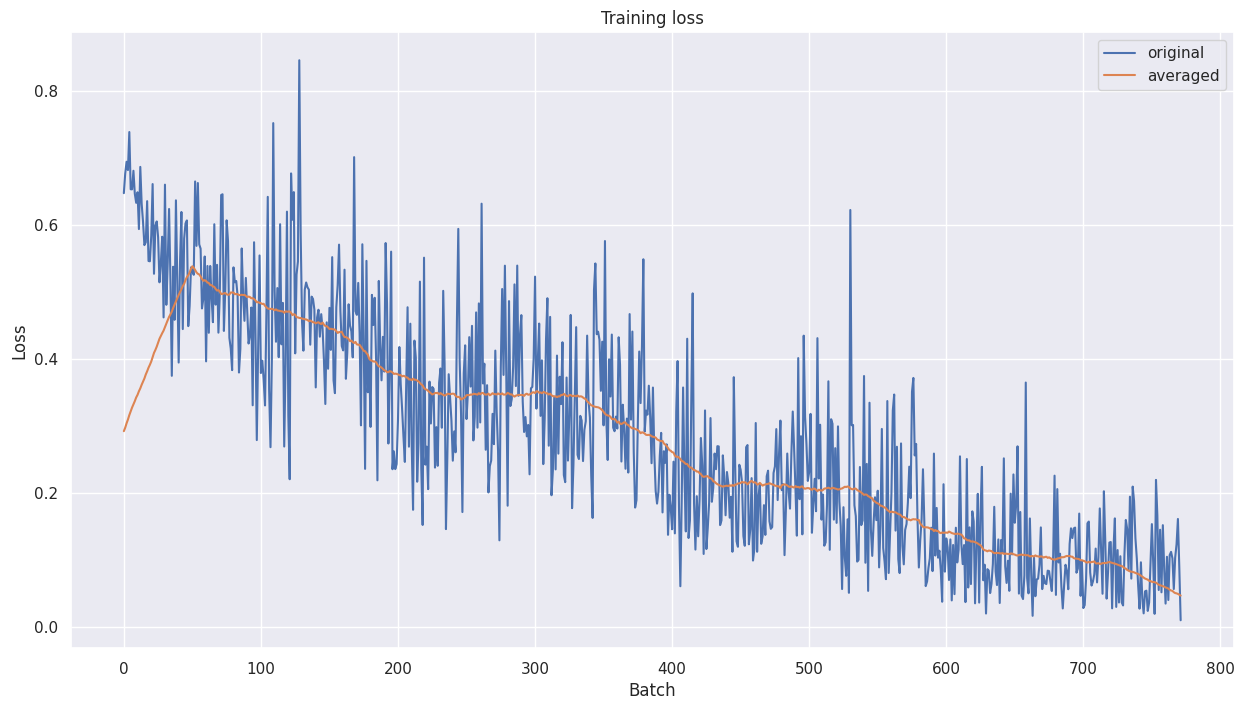

In [30]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()

Let's visualize the loss trend on the training and evaluation dataset per epoch.

As said before, the training loss is decaying, but the validation loss is increasing after the second epoch. This is a signal of overfitting: the model is not really learning from the training set, but rather memorizing it, which hurts its capacility to generalize on the validation set.

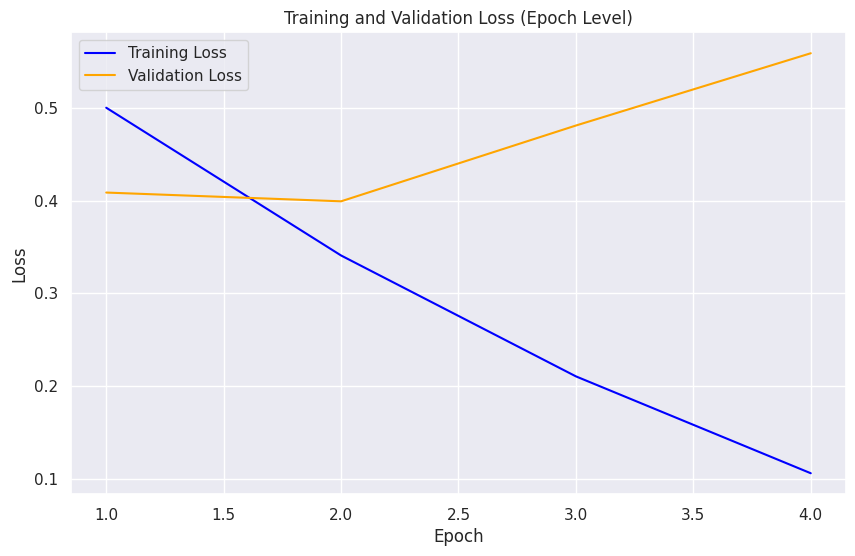

In [31]:
# Calculate epoch-level losses → lists w/ the avg loss for each epoch
# len(dataloader): number of batches to process the entire dataset in one epoch
  #for i in range(0, len(lossv), len(dataloader): we iterate over the entire loss vector, w/ a step equal to the n. of batches in one epoch (aka step = one epoch)
  #lossv[i:i + len(dataloader)]: we slice the loss vector to select the batch losses for one epoch → over this slice, we calculate the avg → avg loss for the epoch
epoch_train_loss = [np.mean(train_lossv[i:i + len(train_dataloader)]) for i in range(0, len(train_lossv), len(train_dataloader))]
epoch_eval_loss = [np.mean(eval_lossv[i:i + len(validation_dataloader)]) for i in range(0, len(eval_lossv), len(validation_dataloader))]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_train_loss) + 1), epoch_train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(epoch_eval_loss) + 1), epoch_eval_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Epoch Level)')
plt.legend()
plt.show()

## Evaluation

For a better measure of the quality of the model, let's see the model accuracy, precision, recall and F1 score for the two data sets (tweets and news headlines).

In [32]:
#Redefine the evaluate function → classification report + confusion matrix
def evaluate(loader):
  model.eval()

  n_correct, n_all = 0, 0

  all_predictions = []
  all_labels = []

  for batch in loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
      logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)
    n_all += len(labels)

    #Update preds and labels for the classification report
    all_predictions.extend(predictions)
    all_labels.extend(labels)

  print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))

  report = classification_report(all_labels, all_predictions, digits= 4)
  print("Classification Report:\n", report)

  # Create confusion matrix and plot
  conf_matrix = confusion_matrix(all_labels, all_predictions)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=[str(i) for i in range(conf_matrix.shape[1])],
              yticklabels=[str(i) for i in range(conf_matrix.shape[0])])
  plt.title('Confusion Matrix')
  plt.xlabel('Prediction')
  plt.ylabel('Gold')
  plt.show()

------Test set 1 (Tweets):------
Accuracy: [975/1263] 0.7720
Classification Report:
               precision    recall  f1-score   support

           0     0.7842    0.7598    0.7718       641
           1     0.7601    0.7846    0.7722       622

    accuracy                         0.7720      1263
   macro avg     0.7722    0.7722    0.7720      1263
weighted avg     0.7724    0.7720    0.7720      1263



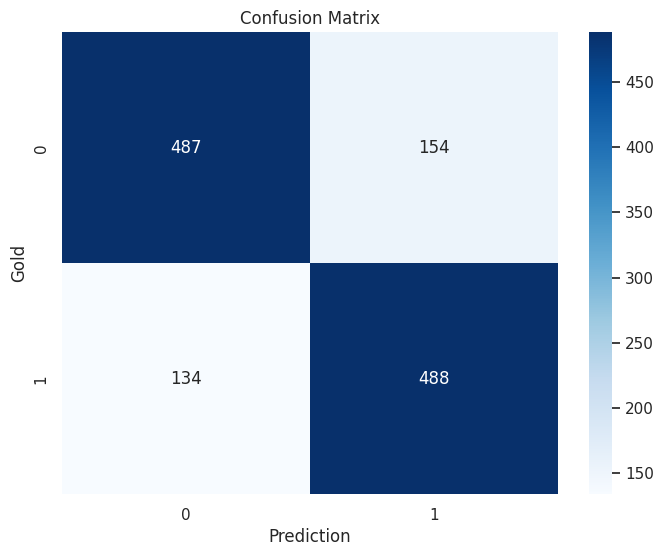

In [33]:
print('------Test set 1 (Tweets):------')
evaluate(test_dataloader_tweets)

------Test set 2 (News):------
Accuracy: [386/500] 0.7720
Classification Report:
               precision    recall  f1-score   support

           0     0.7556    0.9498    0.8417       319
           1     0.8384    0.4586    0.5929       181

    accuracy                         0.7720       500
   macro avg     0.7970    0.7042    0.7173       500
weighted avg     0.7856    0.7720    0.7516       500



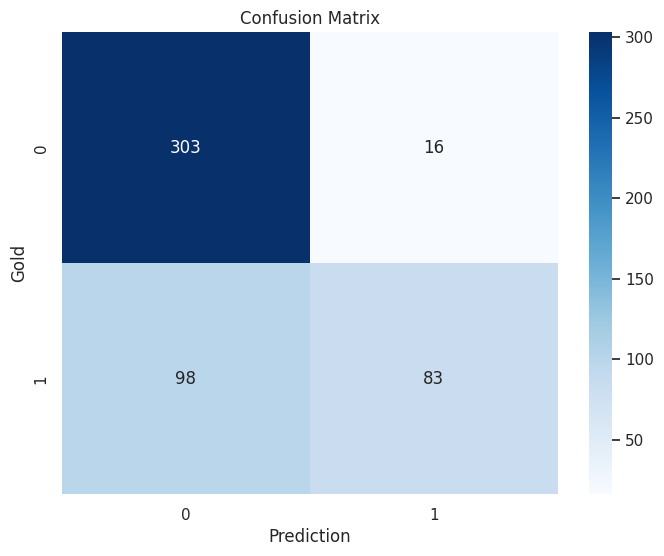

In [34]:
print('------Test set 2 (News):------')
evaluate(test_dataloader_news)